In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequentia.preprocessing import Preprocess, downsample, center, fft, filtrate

seed = 1
np.random.seed(seed)
rng = np.random.RandomState(seed)

# Preprocessing

This tutorial notebook describes the preprocessing methods offered by Sequentia.

---

- [Preprocessing methods](#Preprocessing-methods)
  - [Downsampling (`downsample`)](#Downsampling-%28downsample%29)
    - [Averaging](#Averaging)
    - [Decimation](#Decimation)
  - [Centering (`center`)](#Centering-%28center%29)
  - [Discrete Fourier Transform (`fft`)](#Discrete-Fourier-Transform-%28fft%29)
  - [Filtering (`filtrate`)](#Filtering-%28filtrate%29)
    - [Median filtering](#Median-filtering)
    - [Mean filtering](#Mean-filtering)
- [Accepted input formats](#Accepted-input-formats)
- [Combining preprocessing methods (`Preprocess`)](#Combining-preprocessing-methods-%28Preprocess%29)

## Preprocessing methods

Before we can look at the different preprocessing methods, we have to create a multivariate observation sequence, `F`, that we can use:

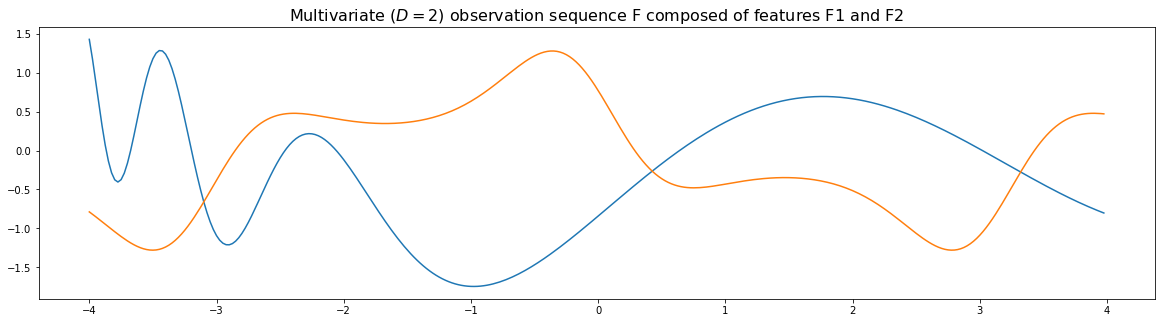

In [2]:
# Specify an input domain for the functions
xs = np.arange(-4., 4., 0.025)

# Create two lambdas that define the features of the observation sequence
f1 = lambda x: (np.sin(x) - np.sin(np.exp(-0.7 * x))).reshape(-1, 1)
f2 = lambda x: (np.exp(np.cos(2*x)) * np.cos(x - 5)).reshape(-1, 1)
# Auxilliary function for downsampling the domain (for plotting)
d = lambda x, n: downsample(x.reshape(-1, 1), n=n, method='decimate')

# Compute function values evaluated on the provided domain (xs)
F1, F2 = f1(xs), f2(xs)
# Combine F1 and F2 to form the features for the multivariate sequence F
F = np.hstack((F1, F2))

plt.figure(figsize=(20, 5))
plt.title('Multivariate ($D=2$) observation sequence F composed of features F1 and F2', fontsize=16)
plt.plot(xs, F)
plt.show()

### Downsampling (`downsample`)

_Reduces the number of frames in an observation sequence according to a specified downsample factor and one of two methods: **averaging** and **decimation**._

---

As an example, using a downsample factor of $n=5$ (and the decimation method – which is the default), we can significantly reduce the number of frames in the observation sequence:

In [3]:
print('Original shape: {}'.format(F.shape))
print('Downsampled shape (n=5): {}'.format(downsample(F, n=5).shape))

Original shape: (320, 2)
Downsampled shape (n=5): (64, 2)


#### Averaging

_With a downsample factor of $n$, averaging replaces every group of $n$ consequent observations with a new observation given by mean of those observations – reducing the number of frames by approximately $\frac{1}{n}$._

$$\texttt{downsample(sequence, n, method='average')}$$

---

The following plots allow us to see the effects of different downsample factors on the `average` downsampling method:

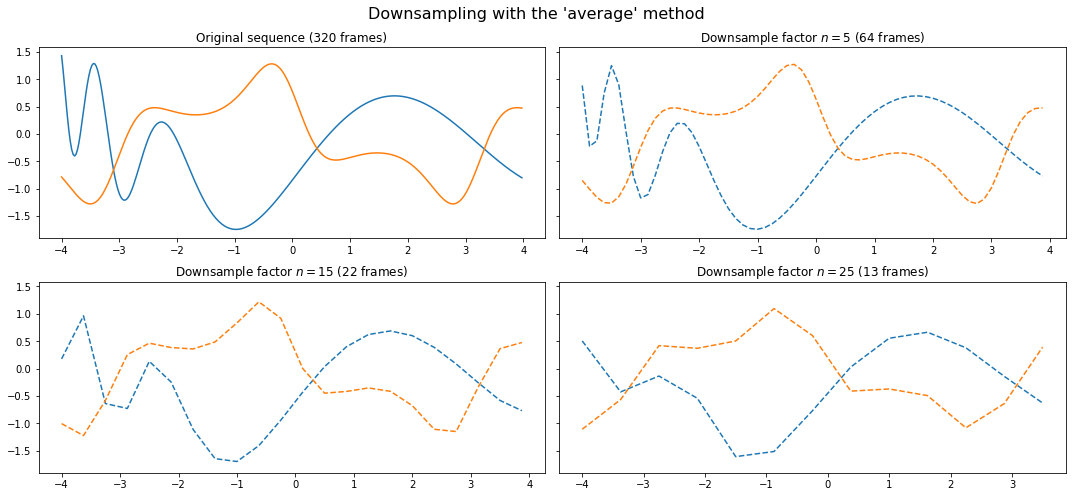

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'average' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = downsample(F, n=5, method='average')
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = downsample(F, n=15, method='average')
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = downsample(F, n=25, method='average')
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Observe that even with just 64 frames, we can still capture most of the important information about the observation sequence – while making the sequence **five times smaller**!

This is often the case with observation sequences that are recorded using very high sample rates.

#### Decimation

_With a downsample factor $n$, decimation keeps every $n^\text{th}$ observation and removes (decimates) the subsequent $n-1$ observations._

$$\texttt{downsample(sequence, n, method='decimate')}$$

---

Once again, we can visualize the effects of the downsample factor by plotting the downsampled sequences.

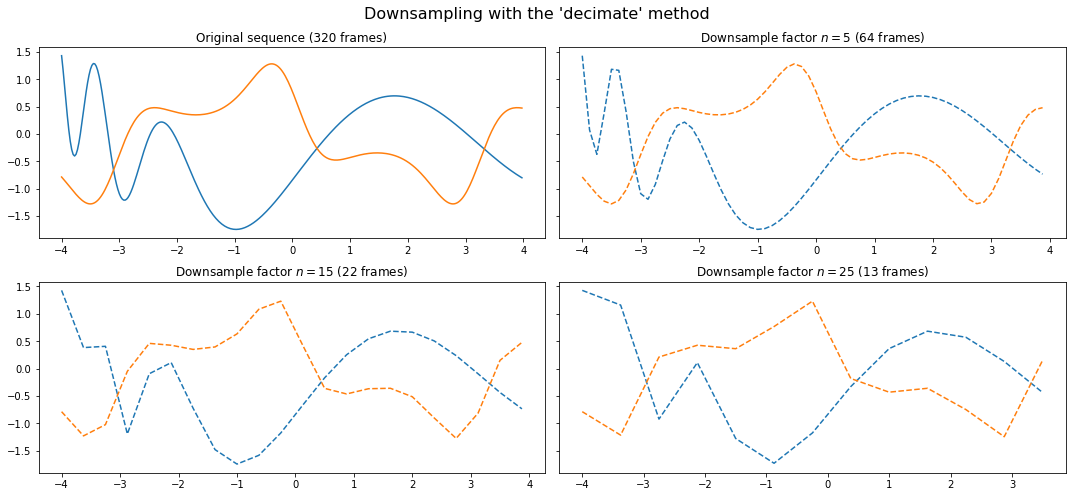

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Downsampling with the 'decimate' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(xs, F)

down = downsample(F, n=5, method='decimate')
axs[0, 1].set_title('Downsample factor $n=5$ ({} frames)'.format(len(down)))
axs[0, 1].plot(d(xs, n=5), down, '--')

down = downsample(F, n=15, method='decimate')
axs[1, 0].set_title('Downsample factor $n=15$ ({} frames)'.format(len(down)))
axs[1, 0].plot(d(xs, n=15), down, '--')

down = downsample(F, n=25, method='decimate')
axs[1, 1].set_title('Downsample factor $n=25$ ({} frames)'.format(len(down)))
axs[1, 1].plot(d(xs, n=25), down, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

From these plots, the differences between downsampling through decimation and averaging aren't immediately obvious.

---

Lets look at a comparison of the two methods using a downsample factor of $n=15$:

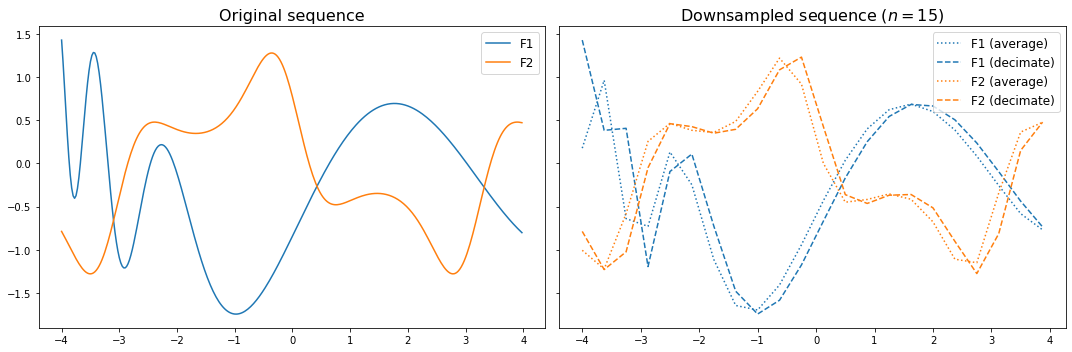

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axs[0].set_title('Original sequence', fontsize=16)
axs[0].plot(xs, F1, label='F1')
axs[0].plot(xs, F2, label='F2')
axs[0].legend(fontsize=12)

axs[1].set_title('Downsampled sequence ($n=15$)', fontsize=16)
axs[1].plot(d(xs, n=15), downsample(F1, n=15, method='average'), 'C0:', label='F1 (average)')
axs[1].plot(d(xs, n=15), downsample(F1, n=15, method='decimate'), 'C0--', label='F1 (decimate)')
axs[1].plot(d(xs, n=15), downsample(F2, n=15, method='average'), 'C1:', label='F2 (average)')
axs[1].plot(d(xs, n=15), downsample(F2, n=15, method='decimate'), 'C1--', label='F2 (decimate)')
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

Once again, it might not be straightforward to choose between the two methods. The best approach would probably be to choose the method that minimizes validation error.

### Centering (`center`)

_Centers an observation sequence by independently centering each feature or dimension separately so that they each have zero mean. This is done by subtracting the mean observation of the sequence from each observation._

$$\texttt{center(sequence)}$$

---

As a simple check on `F`:

In [7]:
np.mean(center(F), axis=0)

array([-8.56953397e-17, -5.93275429e-17])

To see the effects of centering, we can simply plot the centered observation sequence:

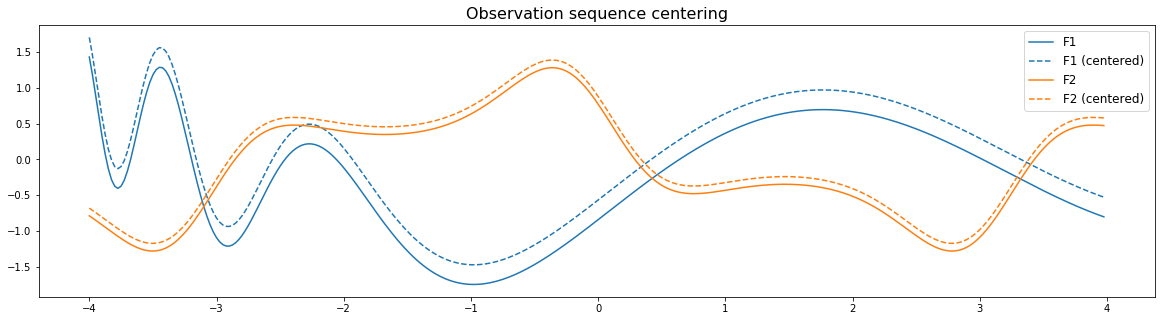

In [8]:
plt.figure(figsize=(20, 5))
plt.title('Observation sequence centering', fontsize=16)
plt.plot(xs, F1, label='F1')
plt.plot(xs, center(F1), 'C0--', label='F1 (centered)')
plt.plot(xs, F2, label='F2')
plt.plot(xs, center(F2), 'C1--', label='F2 (centered)')
plt.legend(fontsize=12)
plt.show()

### Discrete Fourier Transform (`fft`)

_Converts the observation sequence into a real-valued, same-length sequence of equally-spaced samples of the discrete-time Fourier transform._

$$\texttt{fft(sequence)}$$

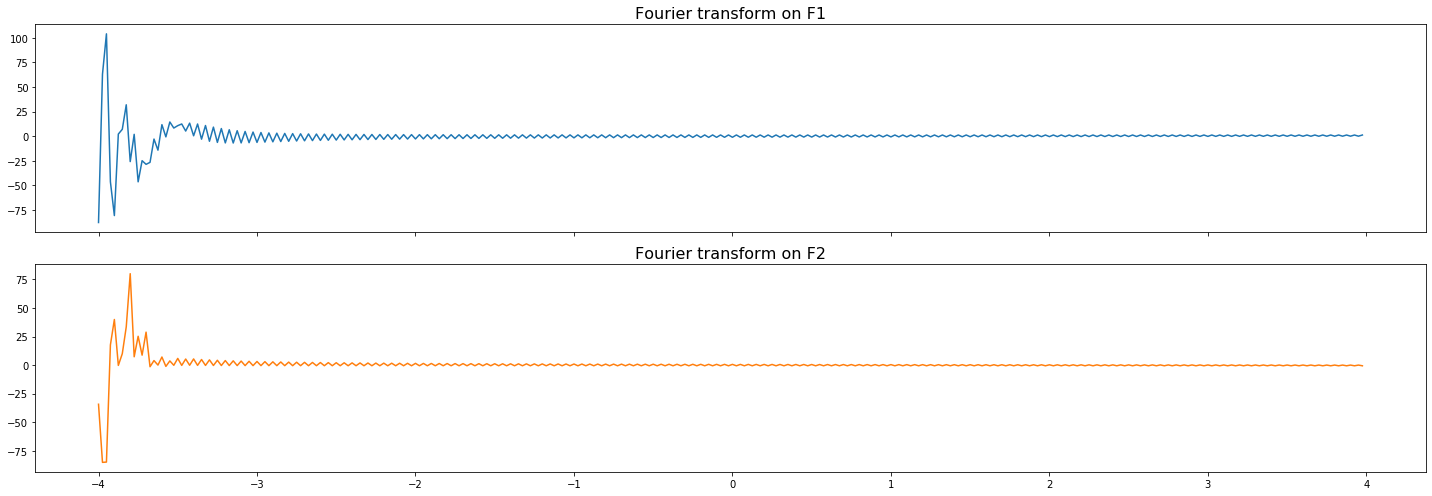

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(20, 7), sharex=True)
axs[0].plot(xs, fft(F1), 'C0')
axs[0].set_title('Fourier transform on F1', fontsize=16)
axs[1].plot(xs, fft(F2), 'C1')
axs[1].set_title('Fourier transform on F2', fontsize=16)
plt.tight_layout()
plt.show()

### Filtering (`filtrate`)

_Removes some unwanted components (such as noise) from an observation sequence according to some window size and one of two methods: **median** and **mean** filtering._

---

To demonstrate and visualize filtering methods, we need to add some noise to the original observation sequence.

In [10]:
# Add noise to the original observation sequence
noise = 0.2 * rng.normal(0, 1, F.shape)
F_noisy = F + noise

#### Median filtering

_With a window size of $n$, median filtering replaces every observation $\mathbf{o}^{(t)}$ with the median of the window of observations of size $n$ containing $\mathbf{o}^{(t)}$ in its centre – that is, $\mathbf{o}^{(t)\prime}=\mathrm{med}\underbrace{\left[\ldots, \mathbf{o}^{(t-1)}, \mathbf{o}^{(t)}, \mathbf{o}^{(t+1)}, \ldots\right]}_n$_

$$\texttt{filtrate(sequence, n, method='median')}$$

---

The following plots allow us to see the effects of different window sizes on the `median` downsampling method:

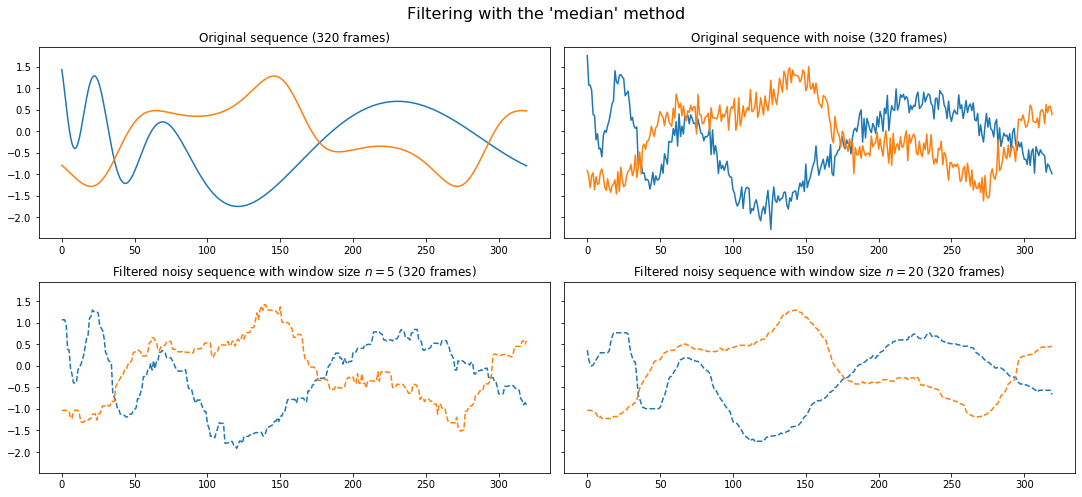

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Filtering with the 'median' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(F)

axs[0, 1].set_title('Original sequence with noise ({} frames)'.format(len(F_noisy)))
axs[0, 1].plot(F_noisy)

filtered = filtrate(F_noisy, n=5, method='median')
axs[1, 0].set_title('Filtered noisy sequence with window size $n=5$ ({} frames)'.format(len(filtered)))
axs[1, 0].plot(filtered, '--')

filtered = filtrate(F_noisy, n=20, method='median')
axs[1, 1].set_title('Filtered noisy sequence with window size $n=20$ ({} frames)'.format(len(filtered)))
axs[1, 1].plot(filtered, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The median filter does a good job at reducing the noise! With generally a smoother function as the window size increases.

#### Mean filtering

_With a window size of $n$, mean filtering replaces every observation $\mathbf{o}^{(t)}$ with the mean of the window of observations of size $n$ containing $\mathbf{o}^{(t)}$ in its centre – that is, $\mathbf{o}^{(t)\prime}=\mathrm{mean}\underbrace{\left[\ldots, \mathbf{o}^{(t-1)}, \mathbf{o}^{(t)}, \mathbf{o}^{(t+1)}, \ldots\right]}_n$_

$$\texttt{filtrate(sequence, n, method='mean')}$$

---

The following plots allow us to see the effects of different window sizes on the `mean` downsampling method:

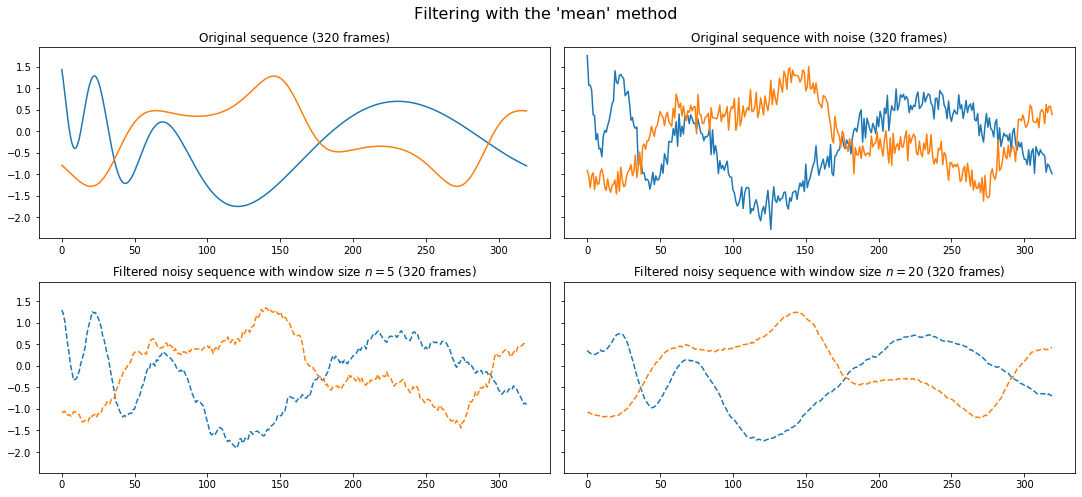

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True) 
fig.suptitle("Filtering with the 'mean' method", fontsize=16)

axs[0, 0].set_title('Original sequence ({} frames)'.format(len(F)))
axs[0, 0].plot(F)

axs[0, 1].set_title('Original sequence with noise ({} frames)'.format(len(F_noisy)))
axs[0, 1].plot(F_noisy)

filtered = filtrate(F_noisy, n=5, method='mean')
axs[1, 0].set_title('Filtered noisy sequence with window size $n=5$ ({} frames)'.format(len(filtered)))
axs[1, 0].plot(filtered, '--')

filtered = filtrate(F_noisy, n=20, method='mean')
axs[1, 1].set_title('Filtered noisy sequence with window size $n=20$ ({} frames)'.format(len(filtered)))
axs[1, 1].plot(filtered, '--')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Similarly to the downsampling methods, it often isn't clear which of the filtering methods will perform best.

## Accepted input formats

Just as with the `fit()` and `predict()` functions on the Sequentia classifiers, each of the preprocessing functions accepts:

- `numpy.ndarray`: A single multivariate observation sequence
- `list(numpy.ndarray)`: Multiple multivariate observation sequences

**Note**: The observation sequences must strictly have a second dimension. If using one-dimensional observation sequences, these must be reshaped from `(T,)` to `(T, 1)`, where `T` is the number of frames.

---

Nothing changes about how you call the preprocessing functions:

In [13]:
# Single multivariate observation sequences
down = downsample(F, n=5, method='average')
down.shape

(64, 2)

In [14]:
# Multiple multivariate observation sequences
Fs = [F]*5
down = downsample(Fs, n=5, method='average')
[f.shape for f in down]

[(64, 2), (64, 2), (64, 2), (64, 2), (64, 2)]

## Combining preprocessing methods (`Preprocess`)

It is possible to combine preprocessing methods by simply making repeated function calls, as shown below:

In [15]:
F_pre = F_noisy
F_pre = center(F_pre)
F_pre = filtrate(F_pre, n=10, method='median')
F_pre = downsample(F_pre, n=10, method='decimate')
F_pre = fft(F_pre)

This is fine if we are working with a single observation sequence. However, this **may** be slightly slower when applied to multiple observation sequences. This is due to each preprocessing method call requiring a separate loop through the observation sequences. This way is also a lot less readable.

---

The `Preprocess` class can be used to chain preprocessing method calls in a more efficient manner. To see the difference, lets duplicate the observation sequence `F` that we were using before:

In [16]:
Fs = [F]*10000

Chaining preprocessing method calls:

In [17]:
%%time
F_pre = Fs
F_pre = center(F_pre)
F_pre = filtrate(F_pre, n=10, method='median')
F_pre = downsample(F_pre, n=15, method='decimate');
F_pre = fft(F_pre)

CPU times: user 3min 36s, sys: 1.74 s, total: 3min 37s
Wall time: 3min 49s


Using the `Preprocess` class:

In [18]:
pre = Preprocess()
pre.center()
pre.filtrate(n=10, method='median')
pre.downsample(n=15, method='decimate')
pre.fft()

# Summarize the preprocessing steps
pre.summary()

           Preprocessing summary:          
1. Centering
-------------------------------------------
2. Filtering:
   Median filter with window size (n=10)
-------------------------------------------
3. Downsampling:
   Decimating with downsample factor (n=15)
-------------------------------------------
4. Discrete Fourier Transform


In [19]:
%%time
F_pre = pre.transform(Fs)

CPU times: user 3min 13s, sys: 427 ms, total: 3min 13s
Wall time: 3min 14s


Not much testing has been done to confirm whether one method is actually better than the other, but you can still rely on them giving the same results!